<a href="https://colab.research.google.com/github/manojach87/miscellaneous/blob/master/recommendation_system/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [2]:
! mkdir goodbooks-10k
! mv archive.zip goodbooks-10k
# https://www.kaggle.com/zygmunt/goodbooks-10k

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.
/


In [4]:
! cd goodbooks-10k; unzip archive.zip

Archive:  archive.zip
  inflating: book_tags.csv           
  inflating: books.csv               
  inflating: ratings.csv             
  inflating: sample_book.xml         
  inflating: tags.csv                
  inflating: to_read.csv             


In [6]:
ratings_df = pd.read_csv("goodbooks-10k/ratings.csv") 
books_df = pd.read_csv("goodbooks-10k/books.csv")
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [7]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.nunique())
ratings_df.isna().sum()

(981756, 3)
53424
10000


book_id    0
user_id    0
rating     0
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (785404, 3)
Shape of test data: (196352, 3)


In [9]:
#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()

In [10]:
#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [11]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
_______________________________________________________________________________________

In [12]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/5
12272/12272 [==============================] - 119s 10ms/step - loss: 0.8599 - val_loss: 0.7144
Epoch 2/5
12272/12272 [==============================] - 126s 10ms/step - loss: 0.6849 - val_loss: 0.6995
Epoch 3/5
12272/12272 [==============================] - 124s 10ms/step - loss: 0.6487 - val_loss: 0.6952
Epoch 4/5
12272/12272 [==============================] - 120s 10ms/step - loss: 0.6185 - val_loss: 0.6977
Epoch 5/5
12272/12272 [==============================] - 121s 10ms/step - loss: 0.5893 - val_loss: 0.7029


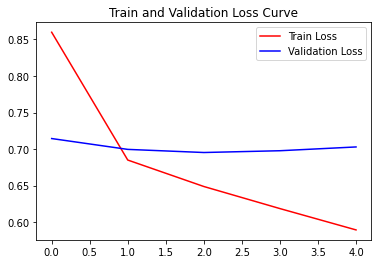

In [13]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [14]:
#save the model
model.save('model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets


In [15]:
# Extract embeddings
book_em = model.get_layer('embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

In [16]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")

In [17]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

In [18]:
#Making recommendations for user 100
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

array([[4.046795 ],
       [4.4860964],
       [2.812541 ],
       ...,
       [4.5676804],
       [4.4266467],
       [3.459185 ]], dtype=float32)

In [19]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([6919, 3627, 1787, 6589, 5206])

In [20]:
books_df.iloc[pred_ids]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
6919,6920,24815,24815,25602,19,751500283,9.780752e+12,Bill Watterson,1992.0,The Indispensable Calvin and Hobbes: A Calvin ...,The Indispensable Calvin and Hobbes,eng,4.73,14597,16911,325,19,62,666,2969,13195,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
3627,3628,24812,24812,25599,14,740748475,9.780741e+12,Bill Watterson,2005.0,The Complete Calvin and Hobbes,The Complete Calvin and Hobbes,eng,4.82,28900,29968,861,120,154,693,3117,25884,https://images.gr-assets.com/books/1473064526m...,https://images.gr-assets.com/books/1473064526s...
1787,1788,24813,24813,692719,17,836204387,9.780836e+12,Bill Watterson,1995.0,The Calvin and Hobbes Tenth Anniversary Book,The Calvin and Hobbes Tenth Anniversary Book,eng,4.63,48280,48829,346,346,608,3077,8752,36046,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
6589,6590,59715,59715,1010526,21,751507954,9.780752e+12,Bill Watterson,1990.0,The Authoritative Calvin and Hobbes,The Authoritative Calvin and Hobbes: A Calvin ...,eng,4.73,16087,18198,425,20,61,701,3295,14121,https://images.gr-assets.com/books/1391114055m...,https://images.gr-assets.com/books/1391114055s...
5206,5207,24818,24818,946589,28,836217357,9.780836e+12,Bill Watterson,1993.0,The Days Are Just Packed: A Calvin and Hobbes ...,The Days Are Just Packed: A Calvin and Hobbes ...,en-US,4.68,19143,20374,228,114,149,942,3636,15533,https://images.gr-assets.com/books/1418211162m...,https://images.gr-assets.com/books/1418211162s...


In [21]:
web_book_data = books_df[["book_id", "title", "image_url", "authors"]]
web_book_data = web_book_data.sort_values('book_id')
web_book_data.head()

,book_id,title,image_url,authors
26,1,Harry Potter and the Half-Blood Prince (Harry ...,https://images.gr-assets.com/books/1361039191m...,"J.K. Rowling, Mary GrandPré"
20,2,Harry Potter and the Order of the Phoenix (Har...,https://images.gr-assets.com/books/1387141547m...,"J.K. Rowling, Mary GrandPré"
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,https://images.gr-assets.com/books/1474154022m...,"J.K. Rowling, Mary GrandPré"
17,5,Harry Potter and the Prisoner of Azkaban (Harr...,https://images.gr-assets.com/books/1499277281m...,"J.K. Rowling, Mary GrandPré, Rufus Beck"
23,6,Harry Potter and the Goblet of Fire (Harry Pot...,https://images.gr-assets.com/books/1361482611m...,"J.K. Rowling, Mary GrandPré"


In [22]:
web_book_data.to_json(r'web_book_data.json', orient='records')